In [1]:
import glob
import os
import json
from collections import Counter
#from __future__ import unicode_literals, print_function
#import plac
#from pathlib import Path
import random

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
from spacy.gold import GoldParse


In [ ]:
# test for github #

In [2]:
data_path = './data/'

**Data exploration**

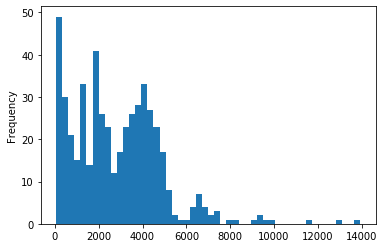

In [15]:
with open(data_path+'exemple_data.json', encoding="utf8") as f:
    data = json.load(f)
    
df=pd.DataFrame(data["articles"])
df['length']=df['content'].apply(len)
df['length'].plot.hist(bins=50)

**Getting data**

In [3]:
nlp = spacy.load('fr_core_news_md')
# nlp1 = spacy.load('fr_core_news_sm')

In [8]:
nlp_0 = spacy.load('fr_core_news_md')

In [3]:
def getFileList(ftypes, start_path = '.'):
    
    file_list = []
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if fp.endswith(ftypes):
                file_list.append(fp)
    
    return file_list

def loadAnnotations(ann_files, txt_files, types):
    ANNOTATIONS = []
    
    for af, tf in zip(ann_files, txt_files):
        with open(af, 'r') as ann_data, open(tf, 'r') as text_data:
            text = text_data.read()
            res = []
            for line in ann_data:
                if line.startswith('T'):
                    content = line.split()
                    if content[1] in types:
                        res.append((int(content[2]), int(content[3]), content[1]))
            if res: ANNOTATIONS.append((text,{"entities": res}))
                
    return ANNOTATIONS

def editAnnotations(raw_annotations, transformation):

    annotation = raw_annotations
    for article in range(len(annotation)):
        output = []
        for item in annotation[article][1]['entities']:
            item = list(item)
            #old_tag = item[2]
            new_tag = transformation.get(item[2],"MISC")
            item[2]=new_tag
            item = tuple(item)
            output.append(item)
        annotation[article][1]['entities'] = output
        
    return annotation

In [4]:
def readAnnotations(raw_data, types, tf=None):
    
    if tf==None:
        articles = raw_data
    else:
        articles = editAnnotations(raw_data, tf)
    outcome = []   
    for i in range(len(articles)):
        example = articles[i]
        mytext = example[0]
        myanns = example[1]['entities']
        for j in range(len(myanns)):
            start, end, cat = myanns[j]
            outcome.append((mytext[start:end], cat))
            
    return outcome

def viewTuples(textlabels):
    for item in textlabels:
        print(item[0], ' : ', item[1])

In [5]:
keys = {
    'Person': 'PER',
    'Location': 'LOC',
    'City': 'LOC',
    'LocalRegion': 'LOC',
    'Country': 'LOC',
    'WordRegion': 'LOC',
    'Organization': 'ORG',
    'Association': 'ORG',
    'GeopoliticalEntity': 'ORG',
    'Company': 'ORG',
    'Media': 'ORG',
    'Role': 'ROL',
    'Currency': 'CUR'
}

intypes = [
    'Person',
    'Location',
    'City',
    'LocalRegion',
    'Country',
    'WordRegion',
    'Organization',
    'Association',
    'GeopoliticalEntity',
    'Company',
    'Media',
    'Role',
    'Currency'
]

ann = getFileList(('.ann'),data_path+'./trainset')
txt  =getFileList(('.txt'),data_path+'./trainset')

in_data = loadAnnotations(ann, txt, intypes)

TRAIN_DATA = editAnnotations(in_data, keys)
len(TRAIN_DATA)

21

In [8]:
TRAIN_DATA[0]

("un petit tour et puis s'en va. natixis n'aura pas fait long feu : un an seulement après son entrée dans le cac40, la banque cède sa place à safran. le symbole est double. d'une part, les valeurs financières pèsent très - trop - lourd dans l'indice, amplifiant en le déformant le signal envoyé au reste du marché. les énormes baisses de capitalisation enregistrées récemment par celles-ci pourraient provoquer d'ailleurs de nouvelles sorties. et de l'autre, il marque le - léger - retour en grâce des valeurs industrielles et technologiques. safran, issue de la fusion de snecmaet de sagem en 2005, n'est pas n'importe laquelle, il est vrai. le motoriste (la propulsion aéronautique et spatiale représente plus de la moitié des 10,8 milliards d'euros de chiffre d'affaires 2010) compte parmi les leaders mondiaux du secteur. associé à general electric au sein de cfm international, safran surfe sur le succès de leur moteur leap qui équipera des milliers d'airbus a320neo et de boeing 737 max ces pr

**Pseudo-rehearsal**

In [16]:
ext_txt = ''.join(df["content"][i] for i in [449, 481, 394, 392, 396])
doc=nlp(ext_txt)
ent = [(ext_txt.index(item.text), ext_txt.index(item.text) + len(item.text), item.label_) for item in doc.ents]

revision_data = (ext_txt,{"entities": ent})
TRAIN_DATA += [revision_data]

In [17]:
len(TRAIN_DATA)

22

**Train the model**

In [53]:
nlp.entity.add_label('ROL')
nlp.entity.add_label('CUR')

if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe("ner")

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]

In [ ]:
# update without parameters optimization

optimizer = nlp.begin_training()
for i in range(10):
    random.shuffle(TRAIN_DATA)
    for text, annotations in TRAIN_DATA:
        nlp.update([text], [annotations], sgd=optimizer)
nlp.to_disk("./model")

In [19]:
loss_values = []

In [54]:
with nlp.disable_pipes(*other_pipes): # only train NER
    # reset and initialize the weights randomly – but only if we're
    # training a new model
    itn_nb = 30

    for itn in range(itn_nb):
        random.shuffle(TRAIN_DATA)
        losses={}
        batches = minibatch(TRAIN_DATA, size=4)
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(
                texts,  # batch of texts
                annotations,  # batch of annotations
                #drop=0.001,  # dropout - make it harder to memorise data
                losses=losses
            )
        print("Losses", losses)
        loss_values.append(losses['ner'])

Losses {'ner': 80.89866255253872}
Losses {'ner': 106.53563234955561}
Losses {'ner': 128.32762517646282}
Losses {'ner': 102.68591119399318}
Losses {'ner': 86.6455823155858}
Losses {'ner': 107.11773688930039}
Losses {'ner': 69.9235797709898}
Losses {'ner': 100.52945231977426}
Losses {'ner': 94.82570346391489}
Losses {'ner': 113.39596822806321}
Losses {'ner': 94.87519758688387}
Losses {'ner': 94.50878464891464}
Losses {'ner': 81.06025976337871}
Losses {'ner': 104.91379019759233}
Losses {'ner': 75.38179134201931}
Losses {'ner': 101.46520256828428}
Losses {'ner': 89.07589704095778}
Losses {'ner': 99.00263314794844}
Losses {'ner': 111.21201478170182}
Losses {'ner': 110.80440228471231}
Losses {'ner': 101.93423019799934}
Losses {'ner': 105.90947878763713}
Losses {'ner': 123.48482524388064}
Losses {'ner': 102.60883842242028}
Losses {'ner': 99.30935062887062}
Losses {'ner': 98.30557899168049}
Losses {'ner': 70.28150163876194}
Losses {'ner': 82.88486272100327}
Losses {'ner': 87.02427746536245}
Lo

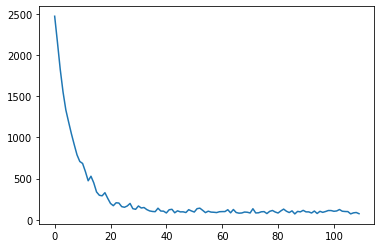

In [55]:
plt.plot(loss_values)
plt.show()

In [80]:
# EVALUATE NER prediction

def evaluate_ner_pred(facts, ypred):
    
    s = 0
    n = len(facts)
    m = len(ypred)
    
    for i in range(m):
        if ypred[i] in facts:
            s += 1
    
    recall = s/n
    
    try:
        precision = s/m
        
    except ZeroDivisionError:
        precision = float('nan')
        
    f1 = 2*(recall*precision)/(recall+precision)
    
    print("Precision : ", precision)
    print('Recall : ', recall)
    print('F1 score : ', f1)
    
    return precision, recall, f1

In [50]:
ann_ = getFileList(('.ann'),data_path+'/testset')
txt_ = getFileList(('.txt'),data_path+'/testset')

test = editAnnotations(loadAnnotations(ann_, txt_, intypes), keys)

In [72]:
test_txt = test[0][0]
doc=nlp(test_txt)
prediction = [(test_txt.index(item.text), test_txt.index(item.text) + len(item.text), item.label_) for item in doc.ents]
truth = test[0][1]['entities']

evaluate_ner_pred(truth, prediction)

Precision :  0.3958333333333333
Recall :  0.2900763358778626
F1 score :  0.33480176211453744


(0.3958333333333333, 0.2900763358778626, 0.33480176211453744)

In [64]:
viewTuples(readAnnotations(test,intypes))

hong kong  :  LOC
fabienne lecorvaisier  :  PER
directrice financière  :  ROL
air liquide  :  ORG
elle  :  PER
mcdonald's  :  ORG
hsbc  :  ORG
administration chinoise  :  ORG
zhou xiaochuan  :  PER
gouverneur  :  ROL
la banque centrale chinoise  :  ORG
chine  :  ORG
shahin vallée  :  PER
chercheur  :  ROL
banque centrale  :  ORG
secrétariat général du parti communiste  :  ORG
pékin  :  ORG
michel aglietta  :  PER
économiste  :  ROL
deng xiaoping  :  PER
alicia garcia-herrero  :  PER
économiste  :  ROL
l'asie de bbva  :  ORG
hong kong  :  LOC
chine  :  LOC
hong kong  :  LOC
lehman  :  ORG
shahin vallée  :  PER
autorités chinoises  :  ORG
zhou xiaochuan  :  PER
etats-unis  :  ORG
occidentaux  :  ORG
pékin  :  ORG
banques centrales  :  ORG
sopanha sa  :  PER
société générale  :  ORG
pékin  :  ORG
chine  :  LOC
corée du sud  :  LOC
japon  :  LOC
asean  :  ORG
chine  :  LOC
sopanha sa  :  PER
hong kong  :  LOC
hsbc  :  ORG
chine  :  LOC
banque centrale  :  ORG
pékin  :  ORG
hong kong  :  LO

** Results Visualization **

In [87]:
myColors = {
    'PER' : '#d7191c',
    'LOC' : '#fdae61',
    'ORG' : '#ffffbf',
    'ROL' : '#abdda4',
    'CUR' : '#2b83ba',
}

displacy.render(nlp(test_txt), jupyter=True, options={'colors':myColors}, style='ent')

**Ground Truth Visualization**

In [88]:
sorted_truth = sorted(truth, key=lambda x:x[0])

formatted_truth = {
    "text": test_txt,
    "ents": [{"start": stt, "end": end, "label": lab} for (stt, end, lab) in sorted_truth],
    "title": None
}

displacy.render(formatted_truth, jupyter=True, manual=True, options={'colors':myColors}, style='ent')

In [81]:
row_names = list(set(keys.values()))
row_names.append(' '.join(row_names))
# row_names = ['LOC', 'ROL', 'ORG', 'PER', 'LOC ROL ORG PER']
col_names = ['Precision', 'Recall', 'F1']
data = []

for label in row_names:
    fct = [item for item in facts if item[2] in label]
    prd = [item for item in prediction if item[2] in label]
    data.append(list(evaluate_ner_pred(fct, prd)))

pd.DataFrame(data, columns=col_names, index=row_names)

Precision :  0.3617021276595745
Recall :  0.4857142857142857
F1 score :  0.41463414634146345
Precision :  0.1724137931034483
Recall :  0.14705882352941177
F1 score :  0.15873015873015872
Precision :  0.7857142857142857
Recall :  0.6470588235294118
F1 score :  0.7096774193548386
Precision :  0.8333333333333334
Recall :  0.625
F1 score :  0.7142857142857143
Precision :  nan
Recall :  0.0
F1 score :  nan
Precision :  0.3958333333333333
Recall :  0.2900763358778626
F1 score :  0.33480176211453744


,Precision,Recall,F1
LOC,0.361702,0.485714,0.414634
ORG,0.172414,0.147059,0.158730
PER,0.785714,0.647059,0.709677
ROL,0.833333,0.625000,0.714286
CUR,NaN,0.000000,NaN
LOC ORG PER ROL CUR,0.395833,0.290076,0.334802


In [2]:
import autoannote

In [3]:
keywords = ['US Dollar', 'Australian Dollar', 'Dollar', 'Dollars']

myText = "Dollars News: The Australian Dollar slumped in the face of Swiss Franc and Dollar and recovering US Dollar"

autoannote.generateAnnotations(myText, keywords, 'CUR')

('Dollars News: The Australian Dollar slumped in the face of Swiss Franc and Dollar and recovering US Dollar',
 {'entities': [(97, 106, 'CUR'),
   (18, 35, 'CUR'),
   (75, 81, 'CUR'),
   (0, 7, 'CUR')]})